In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf 

In [ ]:
TRAIN_DIR = "cats_and_dogs_filtered/train"
VALIDATION_DIR = "cats_and_dogs_filtered/validation"

In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = (160,160)

train_dataset = tf.keras.utils.image_dataset_from_directory(TRAIN_DIR,
                                                            shuffle = True,
                                                            batch_size= BATCH_SIZE,
                                                            image_size = IMAGE_SIZE)

In [ ]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(VALIDATION_DIR,
                                                            shuffle = True,
                                                            batch_size= BATCH_SIZE,
                                                            image_size = IMAGE_SIZE)

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(10,10))
for images, labels in train_dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis('off')

create a test dataset by determining how many batches of data are available in the validation 
set and then move 20% to a test set

In [ ]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [ ]:
print(f"Number of validation batches: {tf.data.experimental.cardinality(validation_dataset)}")
print(f"Number of test batches: {tf.data.experimental.cardinality(test_dataset)}")

Configure the dataset for performance.

use buffered prefetching to load images to desk without I/O become blocking

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

Use data augmentation to artificially introduce sample diversity by applying random but realistic transformations to the training data.

this helps expose the model to different aspects of the training data and reduses overfitting

In [8]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2)
])

repeatedly apply these layers to the same image and see the result

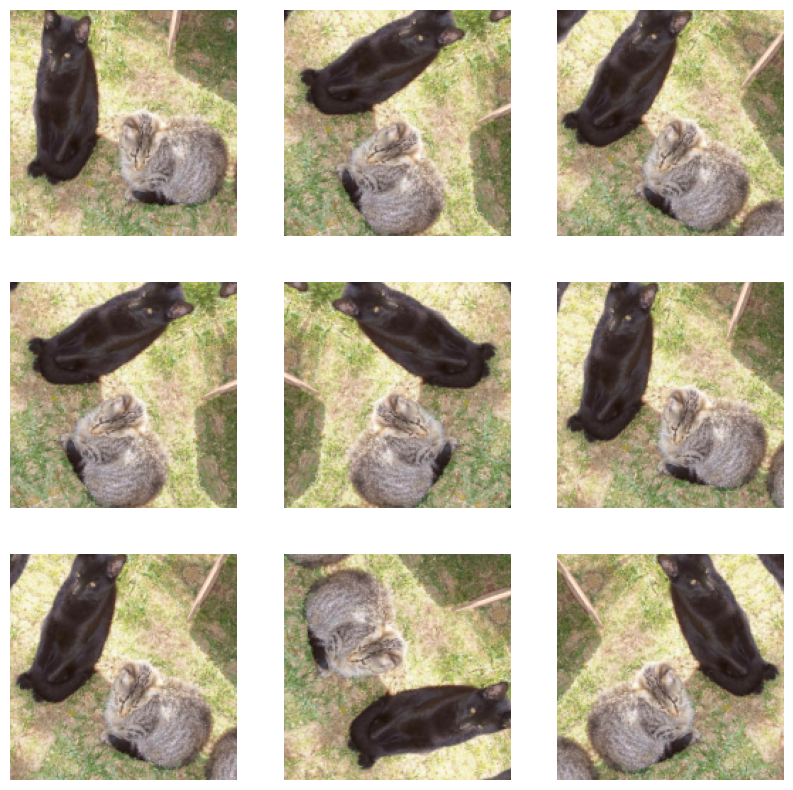

In [9]:
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10,10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

rescale the pixel values

"MobileNetV2" will be used as the base model. this model expects pixel values in the range [-1, 1] but currently the pixel values are
in the range [0, 255].

check the tf.keras.applications API to determine if they expect pixels in range [-1,1] or [0,1], alternatively use .preprocess_input like below

In [10]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

create a base model from a pretrained convnet

MobileNetV2 has been pretrained on the ImageNet dataset.

firstly we need to pick which of MobileNetV2 you will use for feature extraction. 
#    
    - the very last classification layer is not very useful, therefore will use the 'bottleneck layer'

#
instantiate a mobileNetV2 preloaded with weights trained on ImageNet. by specifing 'include_top = False', 
#
you load a network that doesnt include the classification layers at the top.

In [12]:
# create the base model from the pre-trained model MobileNetV2
IMG_SHAPE = IMAGE_SIZE + (3,)

base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                                include_top=False,
                                                weights='imagenet')

9406464/9406464 [==============================] - 14s 2us/step


In [13]:
# this feature extractor converts each 160 * 160 * 3 image into a 5 * 5 * 1280 block of features
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


FEATURE EXTRACTION

for this step we will freeze the convolutional base of "base_model" and use as a feature extractor

Then add a classifier layer on top and train the top level classifier

In [14]:
# freeze the convolutional base, this prevents the weights in a given layer from being updated during training.
# MobileNetV2 has many layers so setting trainable = False will freeze all of them
base_model.trainable = False

In [15]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

ADD A CLASSIFICATION HEAD

to generate predictions from the block of features convert the features to a single 1280 element vector per image               

In [16]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [17]:
# apply a dense layer to convert these features into a single prediction per image
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [18]:
# chain the various layers to the base model

inputs = tf.keras.Input(shape=(160,160,3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training = False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [19]:
# compile the model 

base_learning_rate = 0.0001

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = base_learning_rate),
                loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
                metrics = ['accuracy'])

In [20]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

there are 2.5 million parameters in MobileNet are frozen but there 1281 trainable parameters in the dense layer

these are divided between weights and biases

In [21]:
# TRAIN THE MODEL

initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

32/32 [==============================] - 11s 298ms/step - loss: 0.8989 - accuracy: 0.3960


In [26]:
print(f"Initial loss: {loss0:.4f}")
print(f"Initial accuracy: {accuracy0:.4f}")

Initial loss: 0.8989
Initial accuracy: 0.3960


In [27]:
history = model.fit(train_dataset,\
                    epochs = initial_epochs,
                    validation_data = validation_dataset)

Epoch 1/10
63/63 [==============================] - 30s 410ms/step - loss: 0.7461 - accuracy: 0.5620 - val_loss: 0.6030 - val_accuracy: 0.6540
Epoch 2/10
63/63 [==============================] - 24s 377ms/step - loss: 0.5594 - accuracy: 0.6935 - val_loss: 0.4397 - val_accuracy: 0.7670
Epoch 3/10
63/63 [==============================] - 24s 384ms/step - loss: 0.4520 - accuracy: 0.7715 - val_loss: 0.3392 - val_accuracy: 0.8300
Epoch 4/10
63/63 [==============================] - 24s 385ms/step - loss: 0.3764 - accuracy: 0.8155 - val_loss: 0.2747 - val_accuracy: 0.8850
Epoch 5/10
63/63 [==============================] - 24s 388ms/step - loss: 0.3289 - accuracy: 0.8545 - val_loss: 0.2338 - val_accuracy: 0.9070
Epoch 6/10
63/63 [==============================] - 25s 398ms/step - loss: 0.2940 - accuracy: 0.8670 - val_loss: 0.2041 - val_accuracy: 0.9220
Epoch 7/10
63/63 [==============================] - 27s 428ms/step - loss: 0.2668 - accuracy: 0.8820 - val_loss: 0.1813 - val_accuracy: 0.9320

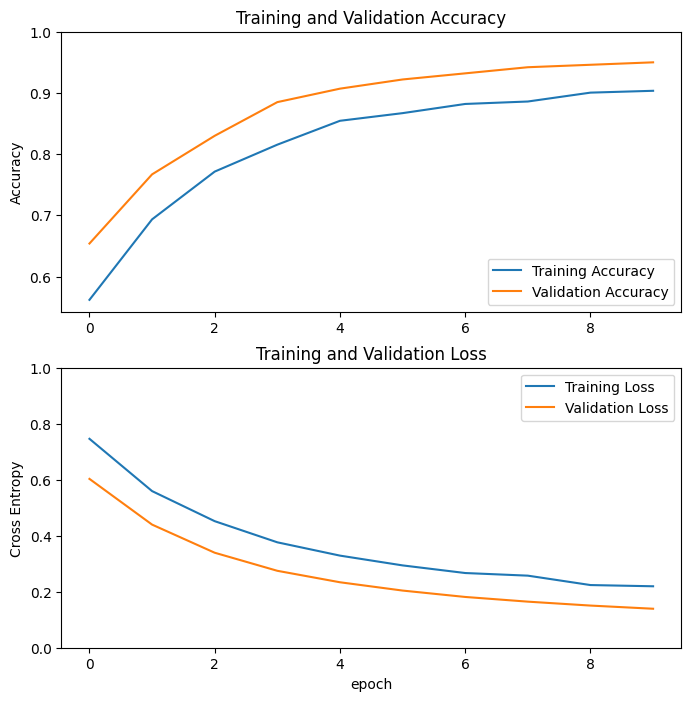

In [28]:
# plot the learning curves
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize = (8, 8))
plt.subplot(2,1,1)
plt.plot(acc, label = 'Training Accuracy')
plt.plot(val_acc, label = "Validation Accuracy")
plt.legend(loc = 'lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label = "Training Loss")
plt.plot(val_loss, label = "Validation Loss")
plt.legend(loc = 'upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, 1.0])
plt.title("Training and Validation Loss")
plt.xlabel("epoch")
plt.show()

why are the validation metrics better than the training metrics?

- the main factor is that layers such as BatchNormalization and Dropout affect accuracy during training, however are turned off when calculating
validation loss.

- to a lesser extenct training metrics report the average of an epoch while validation metrics are calculated after the epoch, so
validation metrics see a model train slightly longer

FINE TUNING

in the feature extraction experiment, only a few layers on top of the MobileNetV2 were trained, the weights of the pretrained network were not updated during training.

to increase performance even more the weights of the top layers of the pretrained model can be trained as well as the training of the classifier (as seen above).

this training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

only finetune a small number of top layers rather than the whole mode. The higher up a layer is the more specialized it is. the first layers learn very simple and generic features that generalize to almost all images. as you go higher up the features are increasingly more specific to the dataset on which the model was trained. the goal of fine tuning is to adopt these specialized features to work with the new dataset rather than overwrite the generic learning

In [29]:
# unfreeze the top layers of the model
# unfreeze the base model and set the bottom layers to untrainable. recompile the model and resume training

base_model.trainable = True

In [30]:
print(f"Number of layers in the base model: {len(base_model.layers)}")

Number of layers in the base model: 154


In [31]:
# fine tune from this layer onwards
fine_tune_at = 100

# freeze all the layers before the 'fine_tune_at' layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

COMPILE THE MODEL

as the model being trained is much larger and the pretrained weights are being readapted, it is important to use a much lower learning rate. This combats the model overfitting very quickly

In [32]:
model.compile(loss= tf.keras.losses.BinaryCrossentropy(from_logits=True),
                optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/ 10),
                metrics = ['accuracy'])

In [33]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [34]:
len(model.trainable_variables)

56

In [35]:
# train the model, this should improve accuracy by a few % points

fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                            epochs = total_epochs,
                            initial_epoch = history.epoch[-1],
                            validation_data = validation_dataset)

Epoch 10/20
63/63 [==============================] - 37s 489ms/step - loss: 0.1671 - accuracy: 0.9290 - val_loss: 0.0658 - val_accuracy: 0.9750
Epoch 11/20
63/63 [==============================] - 30s 476ms/step - loss: 0.1184 - accuracy: 0.9465 - val_loss: 0.0479 - val_accuracy: 0.9780
Epoch 12/20
63/63 [==============================] - 30s 471ms/step - loss: 0.0928 - accuracy: 0.9650 - val_loss: 0.0494 - val_accuracy: 0.9820
Epoch 13/20
63/63 [==============================] - 31s 485ms/step - loss: 0.1014 - accuracy: 0.9590 - val_loss: 0.0442 - val_accuracy: 0.9830
Epoch 14/20
63/63 [==============================] - 32s 504ms/step - loss: 0.0890 - accuracy: 0.9680 - val_loss: 0.0406 - val_accuracy: 0.9820
Epoch 15/20
63/63 [==============================] - 33s 522ms/step - loss: 0.0749 - accuracy: 0.9720 - val_loss: 0.0425 - val_accuracy: 0.9810
Epoch 16/20
63/63 [==============================] - 33s 526ms/step - loss: 0.0747 - accuracy: 0.9705 - val_loss: 0.0784 - val_accuracy: